obs matrix rank =  10
aug sys matrix rank =  13
[-0.1 -0.2 -0.2 -0.2 -0.3 -0.3 -0.3 -0.4 -0.4 -0.4 -0.5 -0.5 -0.5]
L= [[ 1.29603473e+00 -1.23174856e-02 -1.99575754e-02  9.99998904e-02
  -2.45611501e-07  3.49480017e-07  2.68793222e-02  3.01503525e-02
  -6.61709310e-03  2.12308067e-02]
 [-1.23174853e-02  1.33637226e+00  7.43362028e-04  1.13249685e-06
   1.00002547e-01 -3.92495358e-06  5.26538031e-02  9.11451472e-03
   3.04176848e-02  4.01633356e-02]
 [-1.99575755e-02  7.43361966e-04  1.29322663e+00  3.98697876e-07
   8.75016249e-07  9.99986338e-02  2.16681974e-02  9.86746007e-04
   3.13228692e-02  2.00323907e-02]
 [-5.11389569e-07  5.51635030e-05  2.08209103e-05  2.69437073e+00
  -1.27374975e-02  1.92092363e-02  3.85081733e-05  9.80990381e-01
   2.36880688e-05  2.29388079e-05]
 [-1.76658667e-05  1.30767989e-04  4.35368343e-05 -1.27374961e-02
   2.67117855e+00  4.34652229e-02 -9.80919489e-01 -1.71347789e-05
   4.69358248e-05  4.73809871e-05]
 [ 2.37191065e-05 -2.06203392e-04 -7.02885125e-

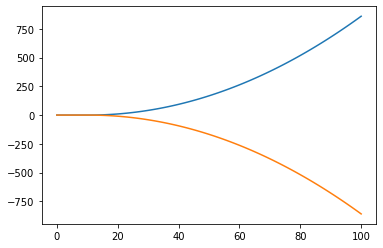

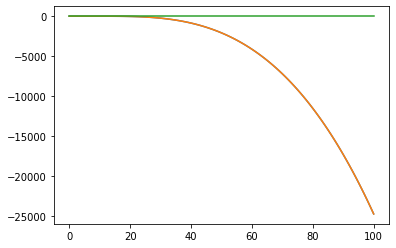

In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from Quadrotor import Quadrotor_linear

from MPC_controller import mpc_control,mpc_control_stable,OTS,get_observer_gain,luenberger_observer
from visualization import data_for_cylinder_along_z
from convexification import get_intermediate_goal, convexify
from test import get_terminal_set_corners

np.random.seed(seed=0)
drone = [0,0,0.05]  #pos_x,pos_y,radius
obs1=np.array([-3,1,1])   #pos_x,pos_y,radius
obs2=np.array([-2,-3,1])  #pos_x,pos_y,radius
obs3=np.array([0,2,1]) #pos_x,pos_y,radius
obs4=np.array([-5,-1.9,1]) #pos_x,pos_y,radius
obs5=np.array([0.5,-2,1]) #pos_x,pos_y,radius
obstacle_list=[obs1,obs2,obs3,obs4,obs5]#,obs6]#,obs1*2,obs2*2,obs3*2,obs4*2,obs5*2]

goal = np.array([-5,-5,2]) #pos_x,pos_y,pos_z

sensor_noise_sigma=np.array([0.05,0.05,0.05,0.001,0.001,0.001,0.001,0.001,0.001,0.001])

real_disturbance=np.random.normal(loc=0,scale=0.01,size=3)
print("real _dist", real_disturbance)

Cd= np.zeros((10,3))

Bd= np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [1, 0, 0],
              [0, 1, 0],
              [0, 0, 1],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])


obs_eigen_values= np.array([-0.1, -0.1, -0.1, -0.03, -0.03, -0.03, 0.3, 0.3, 0.6, 0.6, -0.05, -0.05, -0.05])

def animate(i):
    line.set_xdata(real_trajectory['x'][:i + 1])
    line.set_ydata(real_trajectory['y'][:i + 1])
    line.set_3d_properties(real_trajectory['z'][:i + 1])
    
    line_est.set_xdata(real_trajectory['x'][:i + 1])
    line_est.set_ydata(real_trajectory['y'][:i + 1])
    line_est.set_3d_properties(real_trajectory['z'][:i + 1])
    point.set_xdata(real_trajectory['x'][i])
    point.set_ydata(real_trajectory['y'][i])
    point.set_3d_properties(real_trajectory['z'][i])

if __name__ == "__main__":
    
    N = 10

    quadrotor_linear = Quadrotor_linear()
    
    # Some initialisation
    
    x_init = np.zeros(10)
    x_init[0]=drone[0]
    x_init[1]=drone[1]
    
    x_target = np.zeros(10)
    x_target[0] = goal[0]
    x_target[1] = goal[1]
    x_target[2] = goal[2]
    
    x_hat = x_init
    x_real = x_init
    d_hat=np.zeros((3,1))
    output = x_init
    
    L=get_observer_gain(quadrotor_linear, Bd,Cd,obs_eigen_values)
    
    # Get convex workspace with constraints for obstacles
    A,b = convexify(x_init[:2].flatten(),drone[2],obstacle_list)
    #Get intermediate goal in this convex space
    inter_goal=get_intermediate_goal(x_init[:2].flatten(), 0, x_target[:2].flatten(), A,b).flatten()
    x_intergoal=np.zeros(10)
    x_intergoal[:2]=inter_goal
    x_intergoal[2] = x_target[2]

    real_trajectory = {'x': [], 'y': [], 'z': []}
    est_trajectory = {'x': [], 'y': [], 'z': []}
    output_trajectory = {'x': [], 'y': [], 'z': []}
    
    d_hat_list=[]
    
    # Optimal target selector
    x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A, b, Bd, Cd)

    i = 0
    while np.linalg.norm(x_intergoal[:3].flatten()-x_target[:3]) > 0.1 and i<500: #until intergoal and final goal are equal
        
        i += 1 #limit number of iterations

        # Get obstacle matrix
        A_obs,b_obs=convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

        output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
        
        #Compute the input with mpc
        u = mpc_control(quadrotor_linear, N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A_obs,b_obs,1)

        if u is None:
            # if failure from MPC, u=0, which means hover input
            print("no solution")
            u=np.zeros((4,1))
        else:
            u = u.reshape(-1,1)

        est_trajectory['x'].append(x_hat[0])
        est_trajectory['y'].append(x_hat[1])
        est_trajectory['z'].append(x_hat[2])
        
        real_trajectory['x'].append(x_real[0])
        real_trajectory['y'].append(x_real[1])
        real_trajectory['z'].append(x_real[2])
        
        output_trajectory['x'].append(output[0])
        output_trajectory['y'].append(output[1])
        output_trajectory['z'].append(output[2])
        
        # Plant
        x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
        #Observer
        x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
        
        d_hat_list.append(d_hat)
        
        #Recompute obstacles and intermediate goal
        A_obs,b_obs = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

        x_intergoal[:2] = get_intermediate_goal(output[:2].flatten(), 0,x_target[:2].flatten(), A_obs,b_obs).flatten()
        
        x_ref,u_ref = OTS(quadrotor_linear, x_intergoal, d_hat, A_obs, b_obs, Bd, Cd)

        if x_ref is None : #if failure from target selector
            x_ref = x_intergoal
            u_ref = np.zeros((4,1))
        
        print(i)
        print("x_real :",x_real)
        
    #intermediate goal = final goal, so we pass on stable MPC with time invariant constraints  
    A,b = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)
    print("***")

    while np.linalg.norm(x_real[:3].flatten() - x_target[:3]) >= 0.3 and i<=1000: #until reach final goal
        i+=1
        
        output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
        
        # Use the mpc with terminal cost and set
        u = mpc_control_stable(quadrotor_linear, 3*N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A,b,0.01,1)


        if u is None:
            print("no solution")
            u=np.zeros((4,1))
        else:
            u = u.reshape(-1,1)

        est_trajectory['x'].append(x_hat[0])
        est_trajectory['y'].append(x_hat[1])
        est_trajectory['z'].append(x_hat[2])
        
        real_trajectory['x'].append(x_real[0])
        real_trajectory['y'].append(x_real[1])
        real_trajectory['z'].append(x_real[2])
        
        output_trajectory['x'].append(output[0])
        output_trajectory['y'].append(output[1])
        output_trajectory['z'].append(output[2])
        
        #Plant
        
        x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
        
        #Observer
        x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
        d_hat_list.append(d_hat)
        #Optimal target selector
        x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A,b,Bd,Cd)

        print(i)
        print("x_real :",x_real)
        
        if x_ref is None :#if failure from target selector
            x_ref = x_intergoal
            u_ref = np.zeros((4,1))
    
    
    
    

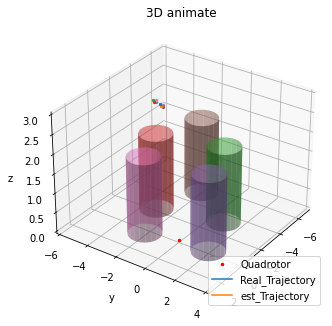

In [4]:
""" Visualisation """
fig = plt.figure(1)
ax1 = p3.Axes3D(fig) # 3D place for drawing
real_trajectory['x'] = np.array(real_trajectory['x'], dtype=float)
real_trajectory['y'] = np.array(real_trajectory['y'], dtype=float)
real_trajectory['z'] = np.array(real_trajectory['z'], dtype=float)

est_trajectory['x'] = np.array(est_trajectory['x'], dtype=float)
est_trajectory['y'] = np.array(est_trajectory['y'], dtype=float)
est_trajectory['z'] = np.array(est_trajectory['z'], dtype=float)

output_trajectory['x'] = np.array(output_trajectory['x'], dtype=float)
output_trajectory['y'] = np.array(output_trajectory['y'], dtype=float)
output_trajectory['z'] = np.array(output_trajectory['z'], dtype=float)
point, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], 'ro', ms=2.5, label='Quadrotor')
line, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], label='Real_Trajectory')
line_est, = ax1.plot([est_trajectory['x'][0]], [est_trajectory['y'][0]], [est_trajectory['z'][0]], label='est_Trajectory')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_xlim3d((-7, 3))
ax1.set_ylim3d((-6, 4))
ax1.set_zlim3d((0, 3))
ax1.set_title('3D animate')
ax1.view_init(30, 35)
ax1.legend(loc='lower right')

for obstacle in obstacle_list:
    Xc,Yc,Zc = data_for_cylinder_along_z(obstacle[0],obstacle[1],obstacle[2],2)
    ax1.plot_surface(Xc, Yc, Zc, alpha=0.5)

points = get_terminal_set_corners(quadrotor_linear, x_target[:3], 0.01)
for point in points:
    ax1.scatter3D(point[0], point[1], point[2], s=5)

ani = animation.FuncAnimation(fig=fig,
                            func=animate,
                            frames=len(real_trajectory['x']),
                            interval=5,
                            repeat=False,
                            blit=False)
plt.show()